<a href="https://colab.research.google.com/github/jcorujo/obligatorio-p1-2023./blob/main/Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipython-input-38-948039920.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


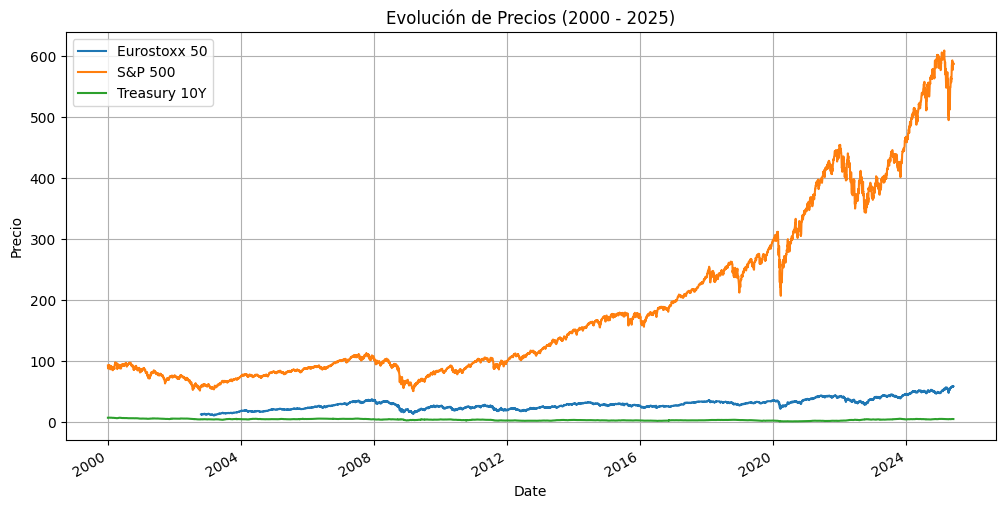

In [ ]:
tickers = ['FEZ', '^TNX', 'SPY']
start_date = '2000-01-01'
end_date = '2025-05-31'
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.columns = ['Eurostoxx 50', 'S&P 500', 'Treasury 10Y']
data.plot(figsize=(12,6), title='Evolución de Precios (2000 - 2025)')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

In [ ]:
treasury_rates = data['Treasury 10Y'].dropna()
retornos_tasa = treasury_rates.diff().dropna() / 100
duration_modificada = 7
retornos_precio_bono = -duration_modificada * retornos_tasa
nivel_confianza = 0.95
percentil_5 = np.percentile(retornos_precio_bono, 100 * (1 - nivel_confianza))
valor_bono = 250000
VaR_absoluto = -percentil_5 * valor_bono
VaR_porcentual = -percentil_5 * valor_bono / valor_bono
print(f"✅ VaR Histórico 1 día - Treasury 10Y (95%)")
print(f"🔹 Valor absoluto: USD {VaR_absoluto:,.2f}")
print(f"🔹 Porcentaje: {VaR_porcentual:.4f}%")

✅ VaR Histórico 1 día - Treasury 10Y (95%)
🔹 Valor absoluto: USD 1,680.00
🔹 Porcentaje: 0.0067%


In [ ]:
from scipy.stats import jarque_bera, norm

In [ ]:
retornos_FEZ = data['Eurostoxx 50'].dropna().pct_change().dropna()
lambdas = np.arange(0.90, 0.99, 0.095)
jb_scores = []
vol_series_dict = {}
def ewma_vol(r, lam):
    ewma = [np.var(r)]  # valor inicial
    for ret in r[1:]:
        ewma.append(lam * ewma[-1] + (1 - lam) * ret**2)
    return np.sqrt(np.array(ewma))

for l in lambdas:
    sigma = ewma_vol(retornos_FEZ.values, l)
    standardized_returns = retornos_FEZ.values[1:] / sigma[:-1]
    jb_stat, _ = jarque_bera(standardized_returns)
    jb_scores.append(jb_stat)
    vol_series_dict[l] = sigma

best_lambda = lambdas[np.argmin(jb_scores)]
best_sigma_series = vol_series_dict[best_lambda]
vol_ewma = best_sigma_series[-1]
mu = retornos_FEZ.mean()
valor_eurostoxx = 200000
z_95 = norm.ppf(0.95)
VaR_pct = -(mu - z_95 * vol_ewma)
VaR_abs = VaR_pct * valor_eurostoxx
print(f"✅ VaR Normal 1 día - Eurostoxx 50 (95%)")
print(f"🔹 Lambda óptimo: {best_lambda:.3f}")
print(f"🔹 Volatilidad EWMA: {vol_ewma:.4%}")
print(f"🔹 VaR absoluto: USD {VaR_abs:,.2f}")
print(f"🔹 VaR porcentual: {VaR_pct:.4%}")

✅ VaR Normal 1 día - Eurostoxx 50 (95%)
🔹 Lambda óptimo: 0.900
🔹 Volatilidad EWMA: 1.0191%
🔹 VaR absoluto: USD 3,271.55
🔹 VaR porcentual: 1.6358%


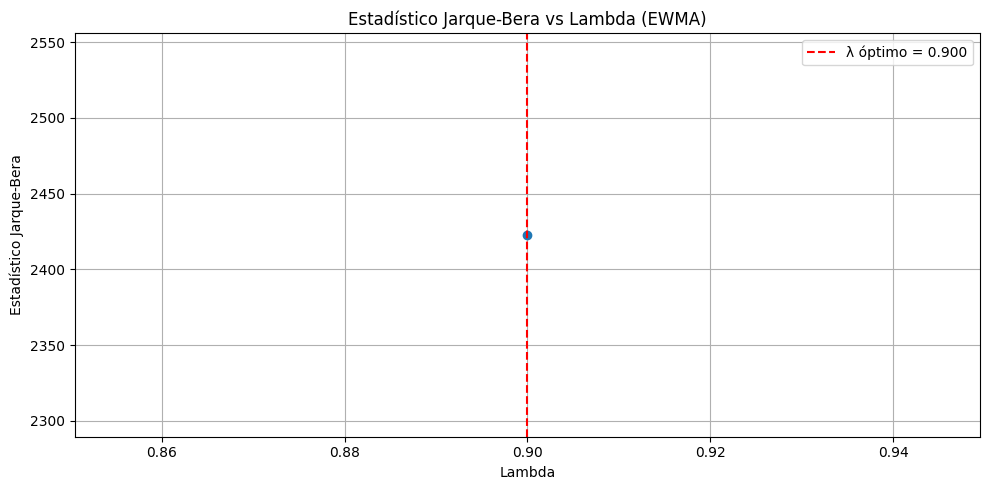

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(lambdas, jb_scores, marker='o', linestyle='-')
plt.axvline(x=best_lambda, color='r', linestyle='--', label=f'λ óptimo = {best_lambda:.3f}')
plt.title('Estadístico Jarque-Bera vs Lambda (EWMA)')
plt.xlabel('Lambda')
plt.ylabel('Estadístico Jarque-Bera')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
retornos = data[['Treasury 10Y', 'S&P 500', 'Eurostoxx 50']].pct_change().dropna()
retornos.columns = ['r', 'S', 'E']
mu_vector = retornos.mean().values
cov_matrix = np.cov(retornos.values.T)
np.random.seed(42)
n_sim = 1000
simulated_factors = np.random.multivariate_normal(mu_vector, cov_matrix, size=n_sim)
dP_P = -2 * simulated_factors[:,0] + 0.3 * simulated_factors[:,1] + 0.3 * simulated_factors[:,2]
valor_portafolio = 650000
losses = -dP_P * valor_portafolio
VaR_MC_1d = np.percentile(losses, 95)
print(f"✅ VaR Monte Carlo 1 día (95%) del portafolio:")
print(f"🔹 Valor absoluto: USD {VaR_MC_1d:,.2f}")
print(f"🔹 Porcentaje sobre portafolio: {VaR_MC_1d / valor_portafolio:.4%}")

✅ VaR Monte Carlo 1 día (95%) del portafolio:
🔹 Valor absoluto: USD 49,503.58
🔹 Porcentaje sobre portafolio: 7.6159%


/tmp/ipython-input-53-1073786983.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos = data[['Treasury 10Y', 'S&P 500', 'Eurostoxx 50']].pct_change().dropna()


In [ ]:
n_dias = 50
n_sim = 1000
valor_inicial = valor_portafolio
simulaciones_factores = np.random.multivariate_normal(mu_vector, cov_matrix, size=(n_sim, n_dias))
valores_portafolio = np.full((n_sim, n_dias+1), valor_inicial)
for t in range(1, n_dias+1):
    dr = simulaciones_factores[:, t-1, 0]
    dS = simulaciones_factores[:, t-1, 1]
    dE = simulaciones_factores[:, t-1, 2]

    dP_P = -2 * dr + 0.3 * dS + 0.3 * dE
    valores_portafolio[:, t] = valores_portafolio[:, t-1] * (1 + dP_P)

perdidas_d20 = valor_inicial - valores_portafolio[:, 20]
perdidas_d50 = valor_inicial - valores_portafolio[:, 50]
VaR_20 = np.percentile(perdidas_d20, 95)
VaR_50 = np.percentile(perdidas_d50, 95)
print(f"✅ VaR Monte Carlo - Día 20 (95%): USD {VaR_20:,.2f} ({VaR_20 / valor_inicial:.4%})")
print(f"✅ VaR Monte Carlo - Día 50 (95%): USD {VaR_50:,.2f} ({VaR_50 / valor_inicial:.4%})")

✅ VaR Monte Carlo - Día 20 (95%): USD 206,628.80 (31.7890%)
✅ VaR Monte Carlo - Día 50 (95%): USD 313,287.75 (48.1981%)


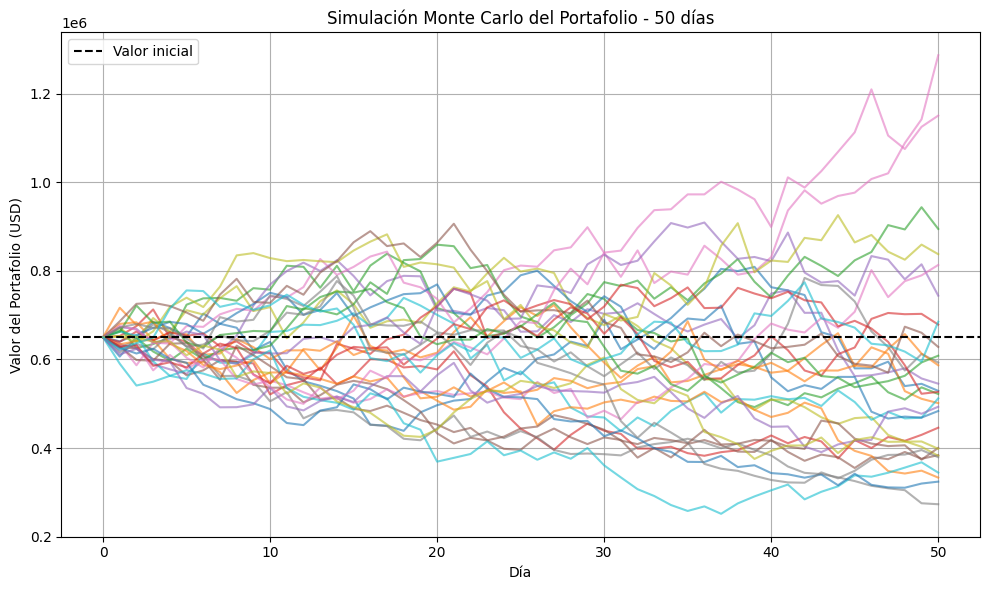

In [ ]:
plt.figure(figsize=(10,6))
for i in range(30):  # 30 caminos aleatorios
    plt.plot(range(n_dias+1), valores_portafolio[i], alpha=0.6)

plt.title('Simulación Monte Carlo del Portafolio - 50 días')
plt.xlabel('Día')
plt.ylabel('Valor del Portafolio (USD)')
plt.axhline(valor_inicial, color='black', linestyle='--', label='Valor inicial')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

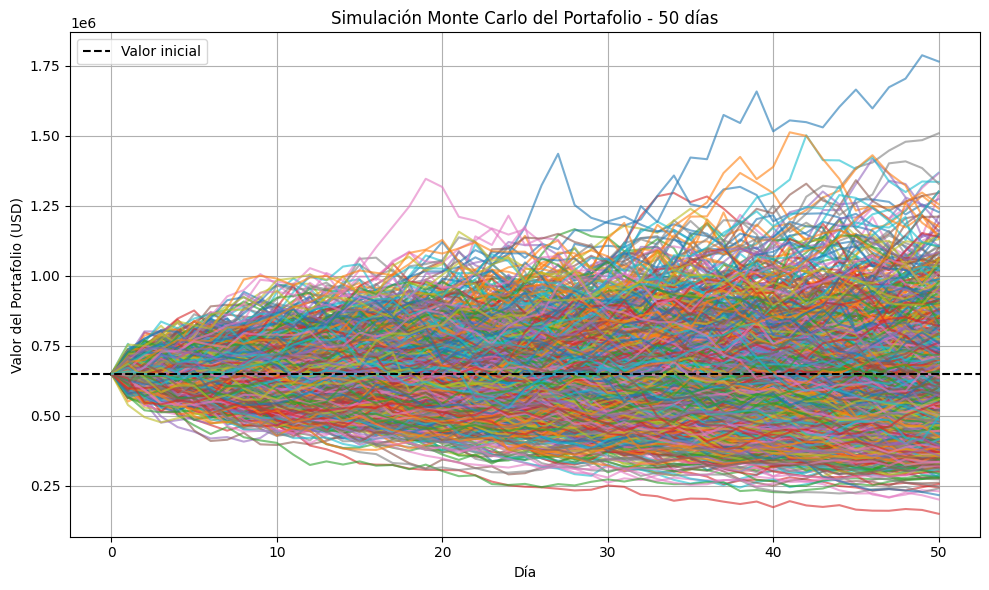

In [ ]:
plt.figure(figsize=(10,6))
for i in range(1000):  # 1000 caminos aleatorios
    plt.plot(range(n_dias+1), valores_portafolio[i], alpha=0.6)

plt.title('Simulación Monte Carlo del Portafolio - 50 días')
plt.xlabel('Día')
plt.ylabel('Valor del Portafolio (USD)')
plt.axhline(valor_inicial, color='black', linestyle='--', label='Valor inicial')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2

In [ ]:
ret_spy = data['S&P 500'].pct_change().dropna()
ret_spy = ret_spy[-500:]
confianza = 0.95
z = norm.ppf(confianza)
window = 250

VaRs = []
excepciones = []

for i in range(window, len(ret_spy)-1):
    window_data = ret_spy[i-window:i]
    mu = window_data.mean()
    sigma = window_data.std()
    var_1d = -(mu - z * sigma)
    VaRs.append(var_1d)

    ret_real = ret_spy.iloc[i+1]
    excepciones.append(ret_real < -var_1d)

n = len(excepciones)
x = sum(excepciones)
p_hat = x / n
p = 1 - confianza

LR_uc = -2 * (np.log(((1 - p) ** (n - x) * p ** x)) - np.log(((1 - p_hat) ** (n - x) * p_hat ** x)))
p_value = 1 - chi2.cdf(LR_uc, df=1)

print(f"✅ Backtesting VaR SPY - Últimos {n} días")
print(f"🔹 Excepciones observadas: {x}")
print(f"🔹 Frecuencia observada: {p_hat:.2%} (esperada: {p:.2%})")
print(f"🔹 LR de Kupiec: {LR_uc:.4f}")
print(f"🔹 p-valor: {p_value:.4f}")

if p_value > 0.05:
    print("📈 No se rechaza H0 → El modelo de VaR es consistente con las excepciones.")
else:
    print("⚠️ Se rechaza H0 → El modelo de VaR subestima el riesgo.")

✅ Backtesting VaR SPY - Últimos 249 días
🔹 Excepciones observadas: 23
🔹 Frecuencia observada: 9.24% (esperada: 5.00%)
🔹 LR de Kupiec: 7.6113
🔹 p-valor: 0.0058
⚠️ Se rechaza H0 → El modelo de VaR subestima el riesgo.


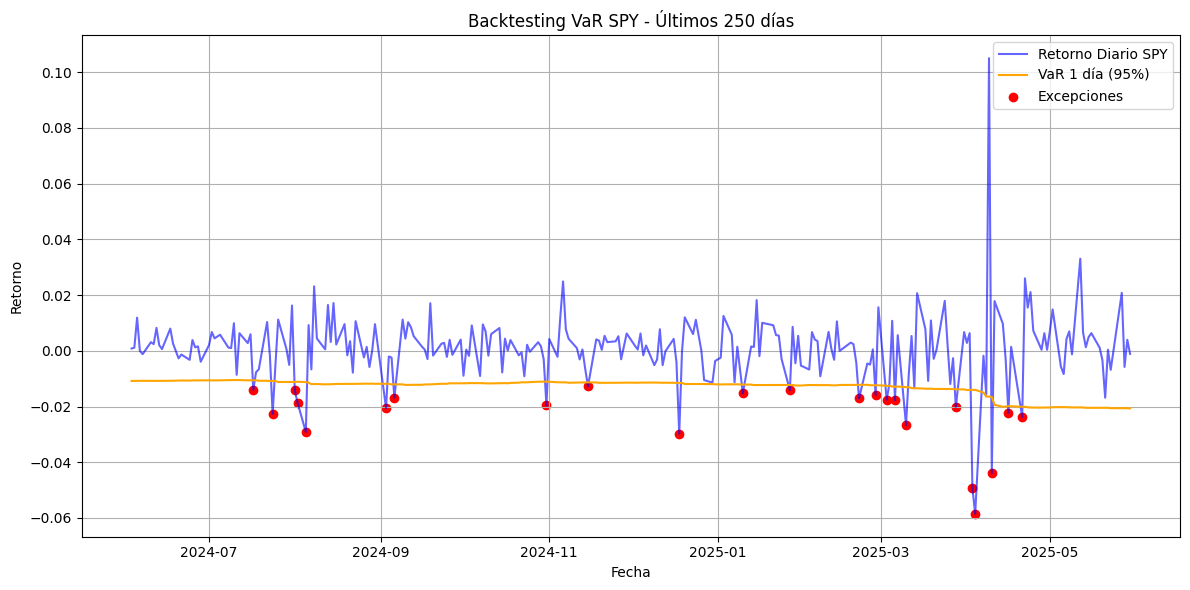

In [ ]:
fechas = ret_spy.index[window+1:]
retornos_real = ret_spy[window+1:].values
VaRs_alineados = np.array(VaRs)
excepciones_array = np.array(excepciones)
plt.figure(figsize=(12,6))
plt.plot(fechas, retornos_real, label='Retorno Diario SPY', color='blue', alpha=0.6)
plt.plot(fechas, -VaRs_alineados, label='VaR 1 día (95%)', color='orange')

plt.scatter(fechas[excepciones_array], retornos_real[excepciones_array], color='red', marker='o', label='Excepciones')

plt.title('Backtesting VaR SPY - Últimos 250 días')
plt.xlabel('Fecha')
plt.ylabel('Retorno')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ventanas = [50, 100, 125, 250, 500]
confianza = 0.95
z = norm.ppf(confianza)

resultados = []

for window in ventanas:
    VaRs = []
    excepciones = []

    if len(ret_spy) - 1 <= window:
        continue

    for i in range(window, len(ret_spy) - 1):
        window_data = ret_spy[i - window:i]
        mu = window_data.mean()
        sigma = window_data.std()
        var_1d = -(mu - z * sigma)
        VaRs.append(var_1d)

        ret_real = ret_spy.iloc[i + 1]
        excepciones.append(ret_real < -var_1d)

    n = len(excepciones)
    x = sum(excepciones)

    if n == 0:
        continue

    p_hat = x / n
    p = 1 - confianza

    if x == 0 or x == n:
        LR_uc = np.nan
        p_value = np.nan
    else:
        LR_uc = -2 * (np.log(((1 - p)**(n - x) * p**x)) - np.log(((1 - p_hat)**(n - x) * p_hat**x)))
        p_value = 1 - chi2.cdf(LR_uc, df=1)

    resultados.append({
        "Ventana": window,
        "Días evaluados": n,
        "Excepciones": x,
        "Frecuencia Observada": p_hat,
        "LR Kupiec": LR_uc,
        "p-valor": p_value
    })
df_resultados = pd.DataFrame(resultados)
pd.options.display.float_format = '{:,.4f}'.format
display(df_resultados)

,Ventana,Días evaluados,Excepciones,Frecuencia Observada,LR Kupiec,p-valor
0,50,449,37,0.0824,8.3745,0.0038
1,100,399,29,0.0727,3.8137,0.0508
2,125,374,28,0.0749,4.2517,0.0392
3,250,249,23,0.0924,7.6113,0.0058


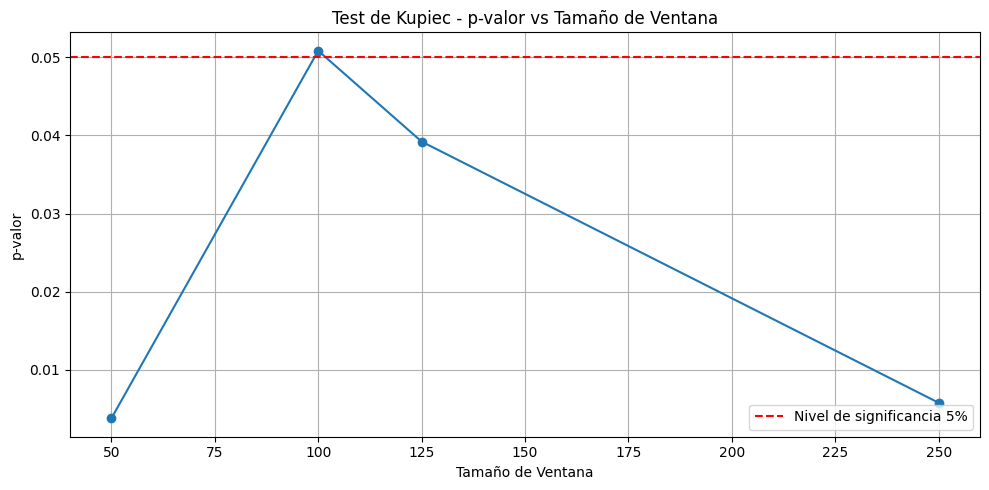

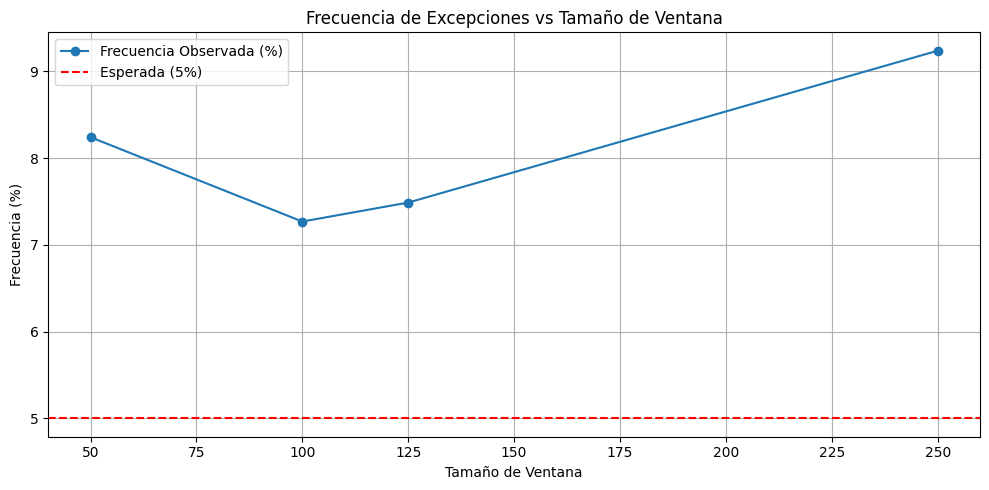

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_resultados['Ventana'], df_resultados['p-valor'], marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='Nivel de significancia 5%')
plt.title('Test de Kupiec - p-valor vs Tamaño de Ventana')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('p-valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df_resultados['Ventana'], df_resultados['Frecuencia Observada'] * 100, marker='o', label='Frecuencia Observada (%)')
plt.axhline(5, color='red', linestyle='--', label='Esperada (5%)')
plt.title('Frecuencia de Excepciones vs Tamaño de Ventana')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('Frecuencia (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()